In [2]:
import numpy as np
import scipy.special as spsc
import sklearn.model_selection as skms
from sklearn import svm

import matplotlib.pyplot as plt
import seaborn as sns

# for plotting in notebooks
%matplotlib inline

# set random seed for reproducibility
np.random.seed(7)

# T12 Classifcation and clustering

## 0 - Neural tuning to visual stimuli

In today's tutorial, we will simulate V1 responses to the presentation of a visual stimulus:

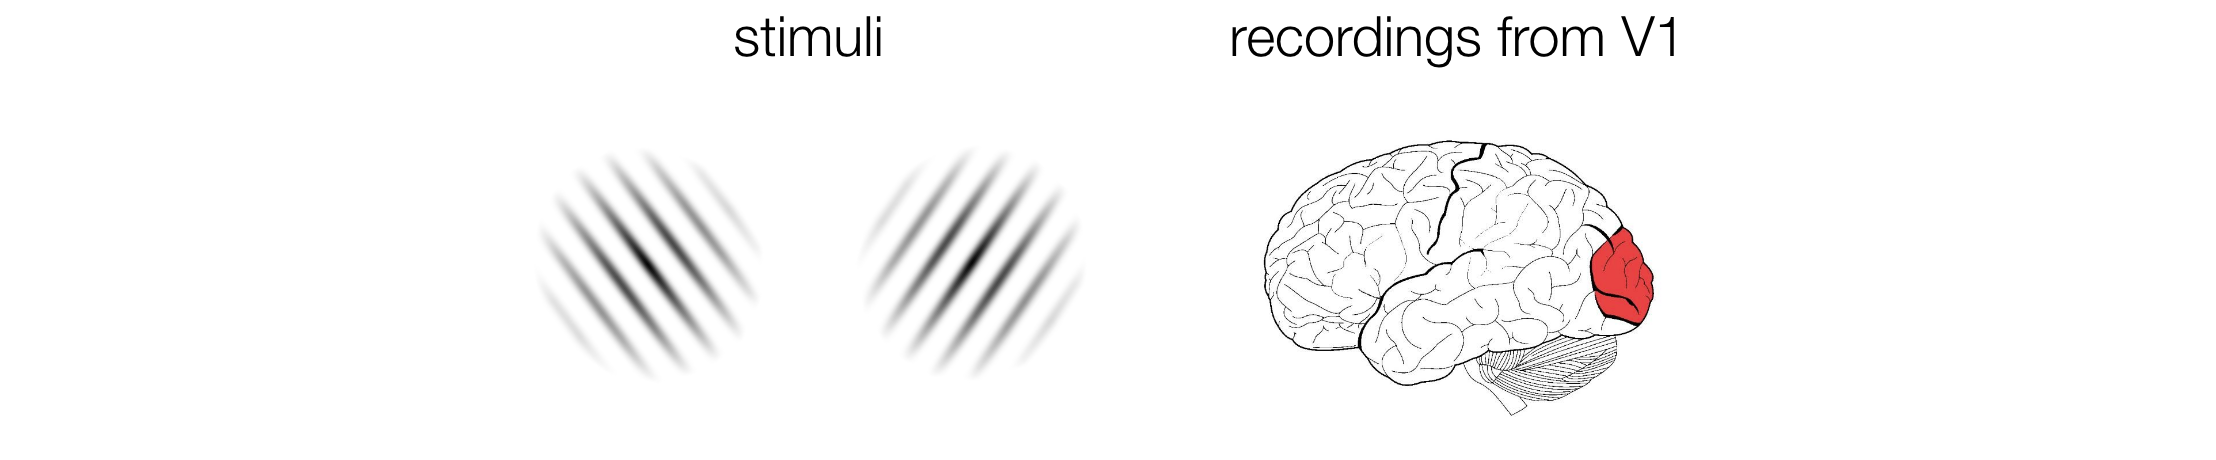

V1 neurons are tuned to directional stimuli, which has been first described by Hubel & Wiesel, 1962. This means that each neuron has a preferred stimulus orientation, for which firing rates are highest. For each neuron, we can plot a tuning curve after measuring responses to all angular values (from $0$ to $\pi$).

We can use this property of stimulus selectivity to reconstruct the stimulus that the animal has seen, simply by looking at the responses of V1 (in neuroscience, this is usually called *decoding*, which is often used synonymously to *classification*).

Later, we will check the decoding performance with cross-validation. 

## 1 - Simulate tuned V1 responses

### Properties of simulated neurons

Create a vector of preferred directions.

In [3]:
n_neurons = 50

# Each neuron prefers a random direction between 0 and pi


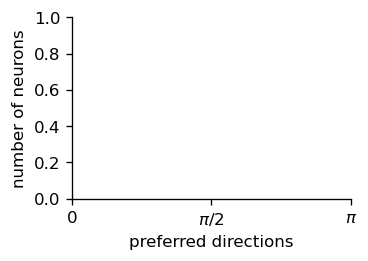

In [4]:
plt.figure(figsize=(3,2), dpi=120)
# plt.hist(preferred_directions, bins=20, color='k')
plt.xticks([0, np.pi/2, np.pi], [0, r'$\pi/2$', r'$\pi$'])
plt.xlabel('preferred directions')
plt.ylabel('number of neurons')
sns.despine()

### Properties of simulated stimuli

In the experiment, there are 200 trials. In each trial, a different randomly chosen orientation is presented. Create the stimuli.

In [5]:
n_stimuli = 200

# Define stimuli: In each of 200 trials, a different random orientation bwetween 0 and pi is presented


### Simulate neural responses

The tuning curves for each neuron are unimodal and look Gaussian, but along a circular variable (the stimulus orientation). A "circular Gaussian" function is called a Van Mises function. Here is a noisy van Mises function that takes the value of each stimulus `x`, the preferred orientation of each neuron `mu`, and the level of noise that we want to simulate.

In [208]:
# probability density of the van Mises distribution
# This function is used to model the circular tuning curve

def noisy_vmdist(x, mu, noiselevel):
    
    kappa = 3.65  # concentration parameter kappa determines the width of the tuning curves
    
    pdf = (1 / (np.pi * spsc.i0(kappa))) * np.exp(kappa * np.cos(2 * (x - mu)))

    noise = np.random.rand(len(x)) * noiselevel
    
    return pdf + noise

Use the Van Mises function to simulate firing rates for each neuron and each stimulus. Create an array `V1_rates` with shape `[n_neurons, n_stimuli]`.

In [8]:
# Create firing rates as a function of presented orientations
noiselevel = 5

# Create V1_rates. Use the Von Mises distribution function defined above.


Using the precoded plotting function, plot a heatmap that shows firing rates for each neuron and each trial. To uncover structure related to neural tuning, sort the heatmap with neuron and trial indices created with `np.argsort()`. 

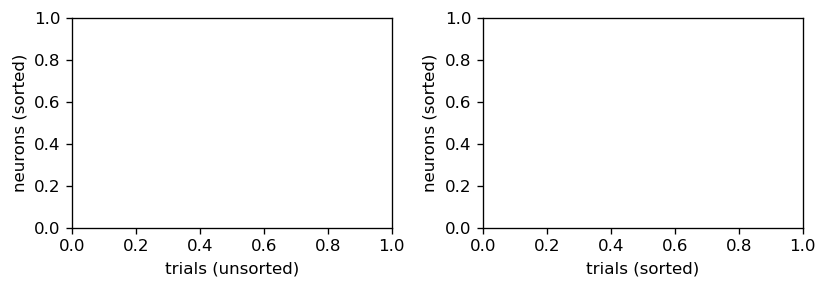

In [12]:
# create two indices to sort neurons by preferred stimulus, and stimuli by presented orientation


# plot V1 responses in different trials, sorted by preferred orientation and stimulus value
plt.figure(figsize=(7,2.5), dpi=120)
plt.subplot(1,2,1)
# plt.imshow(V1_rates[neuron_idx], aspect='auto', cmap='magma')
plt.ylabel('neurons (sorted)')
plt.xlabel('trials (unsorted)')
# plt.colorbar(label='firing rate (Hz)')
plt.subplot(1,2,2)
# plt.imshow(V1_rates[neuron_idx][:,stim_idx], aspect='auto', cmap='magma')
plt.ylabel('neurons (sorted)')
plt.xlabel('trials (sorted)')
# plt.colorbar(label='firing rate (Hz)')
plt.tight_layout()

## 2 - Classify trials as left vs. right from V1 activity

We will now use the simulated activity from V1, as well as the knowledge about the presented stimulus orientation to train a classifier.

### Create labels from stimulus values

First, we will bin presented stimuli as leftward vs. rightward oriented. We will create a new variable, called `labels`, that is 0 for orientations $ < \pi/2$, and 1 for values $ >= \pi/2$.

With the pre-coded plotting function, we will then show the firing rates in a 2-D subspace (out of the full, 50-D neural space).

In [13]:
# create labels


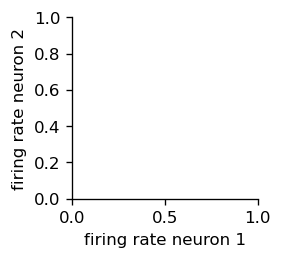

In [14]:
# plot firing rates for two example neurons, color-coded by stimulus type
n1 = 4
n2 = 11

plt.figure(figsize=(2,2), dpi=120)
# plt.plot(V1_rates[n1, labels==0], V1_rates[n2, labels==0], '.', color='darkred')
# plt.plot(V1_rates[n1, labels==1], V1_rates[n2, labels==1], '.', color='lightblue')
plt.xlabel('firing rate neuron 1')
plt.ylabel('firing rate neuron 2')
sns.despine()

As you can see, if we only look at two neurons, the distribution of firing rates is highly overlapping (because of noisy responses, and because we pool over many different stimuli). If we tried to find a decision boundary from 2 neurons alone, we would not achieve a good classification accuracy. 

Let's now train a classifier on the $N_{neurons}$-dimensional space.

### Train-test split for cross-validation

We will create two subsets of trials: A subset used for training, and a subset used for testing. The logic of cross-validation is illustrated in the plot from the lecture:

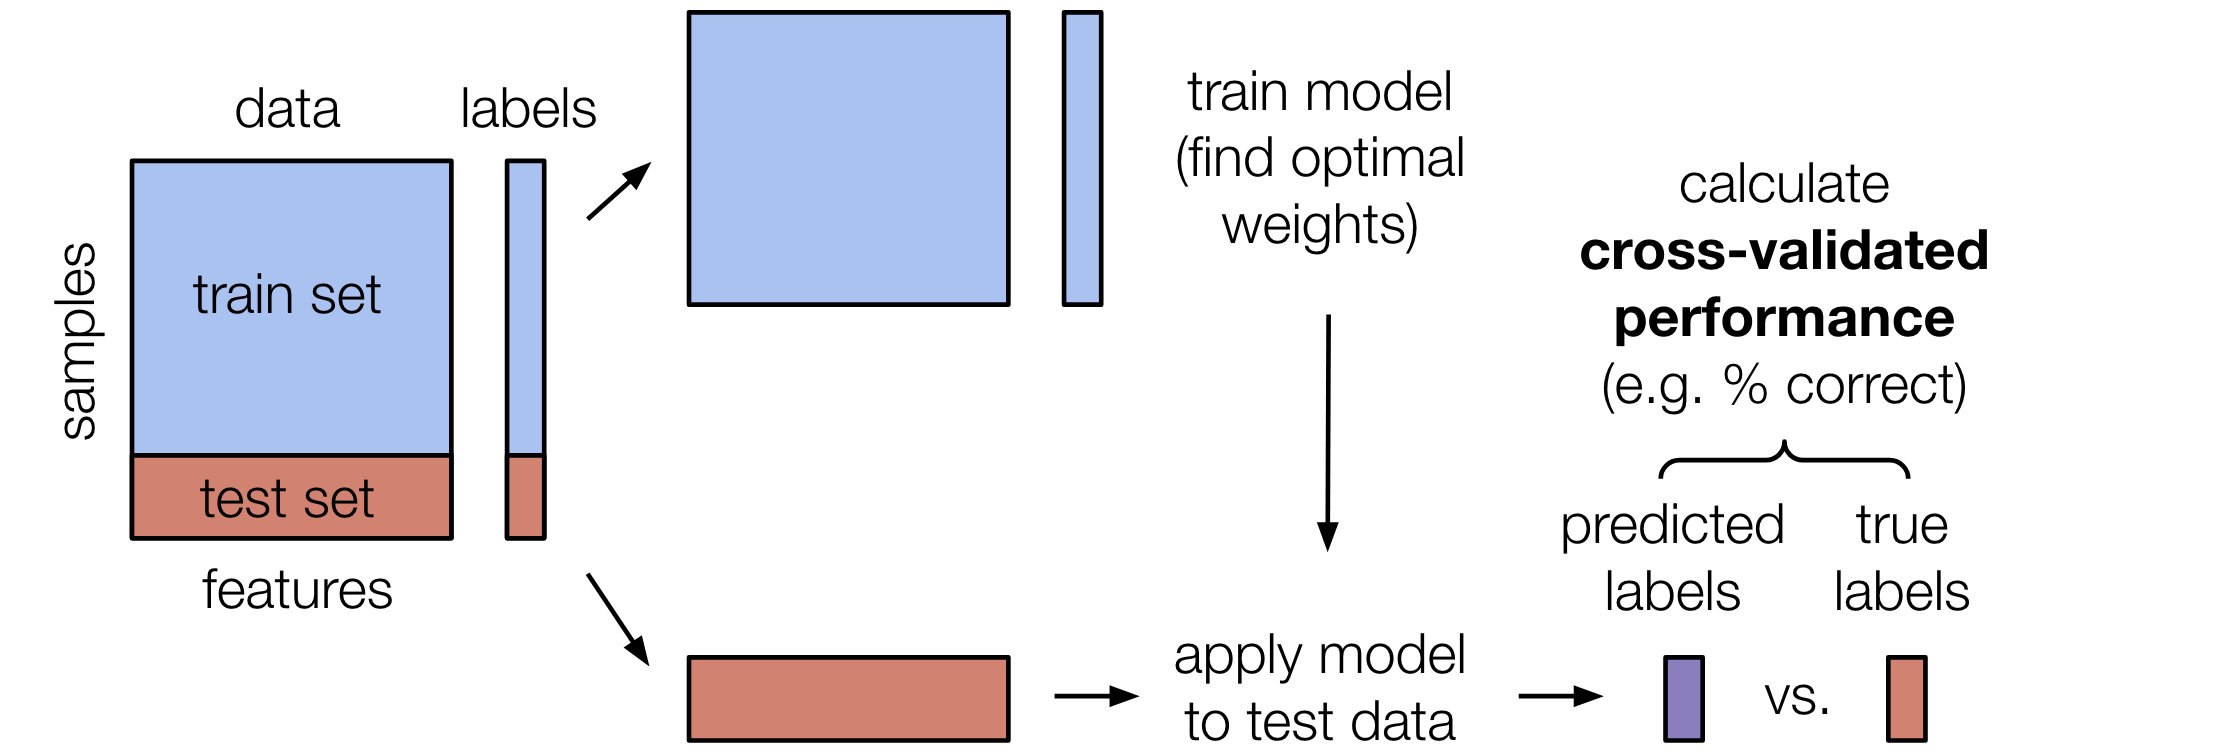

*Samples* correspond to different trials in our dataset. *Features* correspond to different neurons. Use `skms.train_test_split(data, labels)` (from the `sklearn` toolbox) to split the data `V1_rates` and the labels `labels` into a train and test set. Use `test_size = .2` to get a 80/20 split. Note: The function expects data to be in the format `[samples x features]`.

In [16]:
# Create X_train, X_test, y_train, y_test


### Train linear SVM

Use the `svm` package from `sklearn` to implement the support vector machine classifier. 
- You will first have to create an untrained model by calling `model = svm.SVC(kernel = ...)`, indicating the desired kernel (check the documentation). 
- Then, you can fit the model on the training set `X_train, y_train` that we just created.

In [17]:
# create the classifier


# fit/train the classifier


How well can the model separate the data, given knowledge of the labels? Test the performance on the train set, by computing `y_pred` using the `model.predict()` function. Then, compute the percentage of correct classifications.

In [20]:
# test the classification performance on the train set


# percentage correct


How good is the model for making predictions about left-out data? Compute the percentage of correct classificationss on the test set. Does the classifier perform above chance level?

This analysis tells us if the classifier captures any "meaningful" structure in the data, other than the noise structure.

In [21]:
# test the classification performance on the test set


# percentage correct


### Test for significant above-chance classification performance

To ensure that the above-chance performance is significant, we will repeat the analysis several times with independent train-test splits. 

For each of 100 repetions, we will save the train- and test-performance in a two separate lists. Then, we can calculate the 95% confidence interval to ensure that the performance is consistently above chance level.

In [28]:
# number of train-test splits
n_iterations = 100

# create empty lists to save train and test performance

# write a loop
for i in range(n_iterations):
    
    # Create X_train, X_test, y_train, y_test

    # train the classifier
    
    # test the classification performance on the train set

    # test the classification performance on the train set

    # append performance to lists
    
    if np.mod(i, 10)==0: print('iteration: ', i)

iteration:  0
iteration:  10
iteration:  20
iteration:  30
iteration:  40
iteration:  50
iteration:  60
iteration:  70
iteration:  80
iteration:  90


Calculate the 90% confidence interval, by taking the 5th and 95th percentile for each list of classification performances. If the lower value is above the chance level, this indicates significant decoding performance. We will then use the confidence interval to plot train and test performance. 

In [32]:
# calculate 90% CI


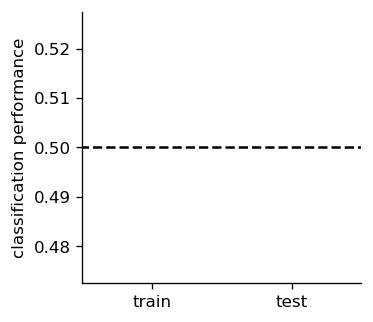

In [33]:
plt.figure(figsize=(3,3), dpi=120)
# plt.plot(np.zeros(n_iterations)+np.random.randn(n_iterations)/20, train_performance, 
#          'k.', alpha=.1)
# plt.plot(np.zeros(2), train_CI, 'k')
# plt.plot(np.ones(n_iterations)+np.random.randn(n_iterations)/20, test_performance, 
#          'b.', alpha=.1)
# plt.plot(np.ones(2), test_CI, 'b')
plt.plot([-1,2], [.5,.5], 'k--')
plt.xlim(-.5,1.5)
plt.ylabel('classification performance')
plt.xticks([0,1], ['train', 'test'])
sns.despine()

Repeat the analysis after changing the noise level in the simulations (e.g. from 1 to 10). How does noise affect decoding performance?

## The end